# Evaluation Experiment Data Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Utilities

def simple_plot(df):
    plt.plot(df['t'], df['P_mW'])
    plt.minorticks_on()
    plt.grid()
    plt.grid(which='minor', ls=':')

def select_time(df, time_slices):
    selected = df['t'] < -100
    for t_min, t_max in time_slices:
        selected = selected | ((df['t'] > t_min) & (df['t'] < t_max))
    return df[selected]

## Calibration

In [3]:
U = 3.7 #V
R = 46.87 #Ohm

def read_csv(path):
    df = pd.read_csv(path, header=0, names=['t', 'UR_V'])
    df['P_mW'] = (df['UR_V'] / R) * (U - df['UR_V']) * 1000
    return df

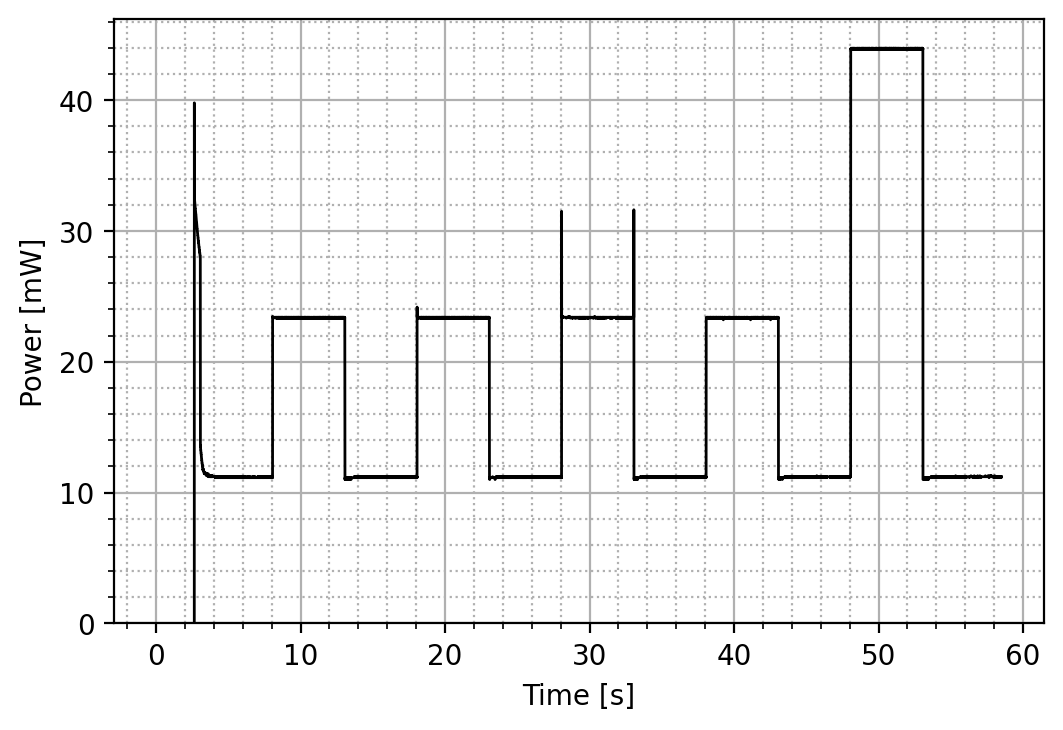

In [4]:
df = read_csv('data/calibration.csv')

plt.figure(dpi=200)
plt.plot(df['t'], df['P_mW'], c='k', lw=1)
plt.ylim(0)
plt.minorticks_on()
plt.grid()
plt.grid(which='minor', ls=':')
plt.xlabel('Time [s]')
plt.ylabel('Power [mW]')
plt.savefig('fig/calibration.pdf')

In [5]:
P_background = select_time(df, [(5, 7), (15, 17), (25, 27), (35, 37), (45, 47)]).mean()['P_mW']
P_background

11.18028827443665

In [6]:
P_LED = select_time(df, [(9, 12), (19, 22), (29, 32), (39, 42)]).mean()['P_mW']
P_LED -= P_background
P_LED

12.193614786126572

In [7]:
P_background = 11.18
P_LED = 12.19

In [8]:
4 * P_LED

48.76

In [9]:
P_4LED = select_time(df, [(49, 52)]).mean()['P_mW']
P_4LED -= P_background
P_4LED

32.72623313126699

In [10]:
P_4LED = 32.73

## Accuracy

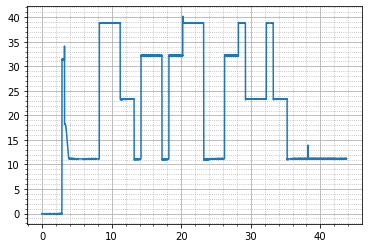

In [11]:
# Manually record last turning point
# 35.216000000	0.324
df_measure = read_csv('data/accuracy.csv')
simple_plot(df_measure)

In [12]:
with open('data/accuracy.out', 'r') as f:
    lines = f.readlines()
lines[:5]

['Global component 0 enters power state LedOn 12.19 mW at 15251 ms\n',
 'App_0 component 0 enters power state None 0 mW at 15251 ms\n',
 'App_1 component 0 enters power state LedOn 12.19 mW at 15251 ms\n',
 'Global component 2 enters power state LedOn 12.19 mW at 15252 ms\n',
 'App_0 component 2 enters power state None 0 mW at 15252 ms\n']

In [13]:
# Only need to consider global power state changes
lines = [line for line in lines if line.startswith('Global')]
lines[:5]

['Global component 0 enters power state LedOn 12.19 mW at 15251 ms\n',
 'Global component 2 enters power state LedOn 12.19 mW at 15252 ms\n',
 'Global component 0 enters power state LedOn 12.19 mW at 15253 ms\n',
 'Global component 1 enters power state LedOn 12.19 mW at 15253 ms\n',
 'Global component 0 enters power state None 0 mW at 18254 ms\n']

In [14]:
def parse(line):
    words = line.split()
    cid = int(words[2])
    power_state = words[6]
    time = int(words[-2])
    if power_state == 'LedOn':
        dp = 12.19
    else:
        dp = -12.19
    return cid, time, power_state, dp

parse(lines[0])

(0, 15251, 'LedOn', 12.19)

In [15]:
# t = [42266 - 35220]
t = [0]
p = [11.18]
epsilon = 0.1

last_state = ['None', 'None', 'None', 'None']
for line in lines:
    cid, time, state, dp = parse(line)

    # Do not consider duplicate power state changes
    if state == last_state[cid]:
        continue
    last_state[cid] = state
    
    t_new = time
    p_new = p[-1] + dp
    t.append(t_new - epsilon)
    p.append(p[-1])
    t.append(t_new)
    p.append(p_new)

df_tet = pd.DataFrame({
    't': np.array(t) / 1000.0,
    'P_mW': p,
})
df_tet.tail()

,t,P_mW
48,40.2590,35.56
49,40.2589,35.56
50,40.2590,23.37
51,42.2659,23.37
52,42.2660,11.18


In [16]:
# Manually sync timeline
df_tet['t'] -= (42.2659 - 35.216)

In [17]:
# Select time range
df_measure = select_time(df_measure, [(8, 36)])
df_tet = select_time(df_tet, [(8, 36)])

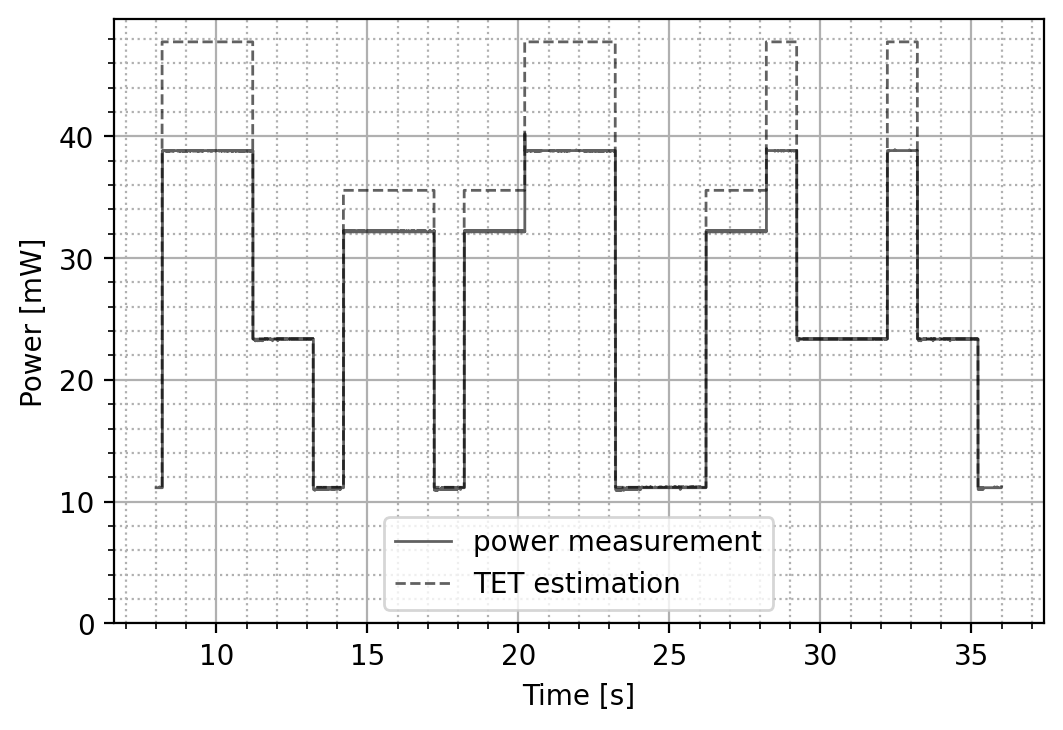

In [18]:
plt.figure(dpi=200)
plt.plot(df_measure['t'], df_measure['P_mW'], c='k', lw=1, alpha=0.618, label='power measurement')
plt.plot(df_tet['t'], df_tet['P_mW'], c='k', lw=1, ls='--', alpha=0.618, label='TET estimation')
plt.ylim(0)
plt.legend(loc=8)
plt.minorticks_on()
plt.grid()
plt.grid(which='minor', ls=':')
plt.xlabel('Time [s]')
plt.ylabel('Power [mW]')
plt.savefig('fig/accuracy.pdf')

## Overhead

### Memory

In [19]:
!cat data/overhead_mem-orig.out

# make build-orig
   text    data     bss     dec     hex filename
 159745      68   24508  184321   2d001


In [20]:
!cat data/overhead_mem-base.out

# make build-base
   text    data     bss     dec     hex filename
 151553      68   24508  176129   2b001


In [21]:
!cat data/overhead_mem-tet.out

# make build-tet
   text    data     bss     dec     hex filename
 180225      68   24504  204797   31ffd


In [22]:
180225 - 151553

28672

In [23]:
28672 / 151553

0.18918794085237509

### Time

In [24]:
!cat data/overhead_time-base.out

Frequency: 32768 Hz
Start time: 499761
End time: 1140887


In [25]:
!cat data/overhead_time-tet.out

Frequency: 32768 Hz
Start time: 499761
End time: 1141454


In [26]:
t_base = (1140887 - 499761) / 32768
t_base #s

19.56561279296875

In [27]:
t_tet = (1141454 - 499761) / 32768
t_tet #s

19.582916259765625

In [28]:
t_overhead = t_tet - t_base
t_overhead

0.017303466796875

In [29]:
t_overhead_rel = t_overhead / t_base
t_overhead_rel

0.0008843815412259056

### Energy

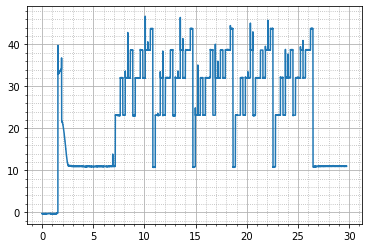

In [30]:
# Mannually record the last turning point:
# 26.460000000	0.680
df_base = read_csv('data/overhead-base.csv')
simple_plot(df_base)

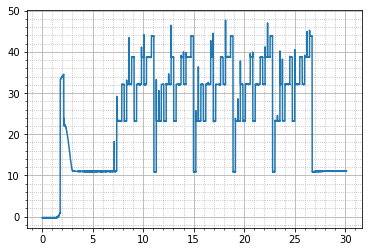

In [31]:
# Mannually record the last turning point:
# 26.716000000	0.681
df_tet = read_csv('data/overhead-tet.csv')
simple_plot(df_tet)

In [32]:
# Manually sync timeline 
df_tet['t'] -= (26.716 - 26.46)

In [33]:
# Select time range to measure
df_base = select_time(df_base, [(7, 27)])
df_tet = select_time(df_tet, [(7, 27)])
dt = 27 - 7 #s

In [34]:
E_base = df_base.mean()['P_mW'] * dt
E_base #mJ

609.8408772430827

In [35]:
E_tet = df_tet.mean()['P_mW'] * dt
E_tet #mJ

611.3947698436638

In [36]:
E_overhead = E_tet - E_base
E_overhead

1.5538926005810936

In [37]:
E_overhead_rel = E_overhead / E_base
E_overhead_rel

0.002548029590285585